# Examining Mental Fatigue Through League of Legends Ranked and Teamfight Tactics (TFT) Gameplay Patterns

## Advanced Data Science Analysis — Gaming Behavior & Cognitive Strain Study

**Student:** Iber Joseph Bonilla  
**Section:** COM222-ML  

### Research Objectives
- **Primary:** Determine how gameplay session frequency, duration, and time of day relate to mental fatigue and focus levels
- **Secondary:** Identify behavioral trends, time-based patterns, and distinct gameplay profiles that may indicate addiction-related behaviors

### Hypotheses Addressed
- **H1:** Longer and more frequent gameplay is associated with higher fatigue and lower focus
- **H2:** Late-night gaming sessions show higher cognitive strain than non-late sessions

---
## 1. Setup and Configuration

In [1]:
# Import libraries for advanced data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr, ttest_ind, f_oneway, shapiro, levene, normaltest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
import os
warnings.filterwarnings('ignore')

# Create results folder and configure saving
RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

def save_fig(name):
    plt.savefig(os.path.join(RESULTS_DIR, name), dpi=150, bbox_inches='tight')

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully. Results will be saved to:", RESULTS_DIR)

Libraries loaded successfully. Results will be saved to: results


---
## 2. Data Loading and Data Dictionary

### Variable Descriptions (Data Dictionary)
| Variable | Type | Unit | Description |
|----------|------|------|-------------|
| Date Played | Date | YYYY-MM-DD | Calendar date of gameplay |
| Session Start Time | Time | 12-hour | When session began |
| Session End Time | Time | 12-hour | When session ended |
| Session Duration (min) | Numeric | minutes | Length of single session |
| Daily Session Count | Numeric | count | Number of sessions that day |
| Total Daily Gaming Duration (min) | Numeric | minutes | Sum of all sessions that day |
| Mental Fatigue Rating | Numeric | 1-10 scale | Self-reported fatigue (10=highest) |
| Focus Rating | Numeric | 1-10 scale | Self-reported focus (10=highest) |
| Hours Awake Before Session | Numeric | hours | Wake time before first session |

In [2]:
# Load dataset
df = pd.read_csv('Final Dataset.csv')

# Display and save initial structure
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head(5).to_csv(os.path.join(RESULTS_DIR, '01_data_head.csv'), index=False)
with open(os.path.join(RESULTS_DIR, '01_data_overview.txt'), 'w') as f:
    f.write(f'Dataset Shape: {df.shape}\n')
df.head()

Dataset Shape: (128, 9)

First 5 rows:


,Date Played,Session Start Time,Session End Time,Session Duration (min),Daily Session Count,Total Daily Gaming Duration (min),Mental Fatigue Rating (1 Lowest),Focus Rating (1 Lowest),Hours Awake Before Session
0,11/21/2025,12:14:00 AM,7:20:00 AM,426,2,560,8,2,2.00
1,11/21/2025,9:41:00 PM,11:55:00 PM,134,2,560,2,3,0.50
2,11/22/2025,3:34:00 AM,6:48:00 AM,194,2,331,2,8,0.25
3,11/22/2025,9:42:00 PM,11:59:00 PM,137,2,331,7,4,3.50
4,11/23/2025,12:00:00 AM,9:42:00 AM,582,1,582,9,3,4.00


In [3]:
# Data types and null check
print("Data Types:")
print(df.dtypes)
print("\n" + "="*50)
print("Null Counts:")
print(df.isnull().sum())
print("\n" + "="*50)
with open(os.path.join(RESULTS_DIR, '02_data_types_null.txt'), 'w') as f:
    f.write(str(df.dtypes) + '\n\n' + str(df.isnull().sum()))
df.info()

Data Types:
Date Played                              str
Session Start Time                       str
Session End Time                         str
Session Duration (min)                 int64
Daily Session Count                    int64
Total Daily Gaming Duration (min)      int64
Mental Fatigue Rating (1 Lowest)       int64
Focus Rating (1 Lowest)                int64
Hours Awake Before Session           float64
dtype: object

Null Counts:
Date Played                          0
Session Start Time                   0
Session End Time                     0
Session Duration (min)               0
Daily Session Count                  0
Total Daily Gaming Duration (min)    0
Mental Fatigue Rating (1 Lowest)     0
Focus Rating (1 Lowest)              0
Hours Awake Before Session           0
dtype: int64

<class 'pandas.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                      

---
## 3. Data Cleaning and Preprocessing

**Cleaning decisions:**
- Handle missing values appropriately
- Remove/flag outliers using IQR method
- Parse dates and times for temporal analysis
- Create derived features: Late Night Gaming, Hour of Day, Day of Week, Cognitive Strain Index
- Exclude zero-session placeholder rows from session-level analysis (keep for daily view)

In [4]:
# Parse Date (handle M/D/YYYY format)
df['Date Played'] = pd.to_datetime(df['Date Played'], format='mixed')

# Parse times - 12-hour format
def parse_time(t):
    if pd.isna(t): return np.nan
    try:
        return pd.to_datetime(t, format='%I:%M:%S %p').time()
    except:
        return pd.to_datetime(t).time()

df['Session_Start'] = df['Session Start Time'].apply(parse_time)
df['Session_End'] = df['Session End Time'].apply(parse_time)

# Extract hour of session start (0-23) for timing analysis
def time_to_hour(t):
    if pd.isna(t): return np.nan
    return t.hour + t.minute/60 + t.second/3600

df['Start_Hour'] = df['Session_Start'].apply(time_to_hour)
df['Date'] = df['Date Played'].dt.date
df['DayOfWeek'] = df['Date Played'].dt.day_name()
df['DayOfWeek_Num'] = df['Date Played'].dt.dayofweek

print("Date and time parsing complete.")
df[['Date Played', 'Session_Start', 'Start_Hour', 'DayOfWeek']].head(10)

Date and time parsing complete.


,Date Played,Session_Start,Start_Hour,DayOfWeek
0,2025-11-21,00:14:00,0.233333,Friday
1,2025-11-21,21:41:00,21.683333,Friday
2,2025-11-22,03:34:00,3.566667,Saturday
3,2025-11-22,21:42:00,21.700000,Saturday
4,2025-11-23,00:00:00,0.000000,Sunday
5,2025-11-24,02:52:00,2.866667,Monday
6,2025-11-25,02:00:00,2.000000,Tuesday
7,2025-11-26,06:37:00,6.616667,Wednesday
8,2025-11-27,07:36:00,7.600000,Thursday
9,2025-11-28,04:33:00,4.550000,Friday


In [5]:
# Define "Late Night" as sessions starting between 10 PM (22:00) and 5 AM (5:00)
# Late = 22:00-23:59 or 0:00-4:59
df['Late_Night'] = ((df['Start_Hour'] >= 22) | (df['Start_Hour'] < 5))

# Cognitive Strain Index: Higher fatigue + Lower focus = Higher strain (normalized 0-1)
# Strain = (Fatigue/10) * (1 - Focus/10) — when focus is low and fatigue high, strain is high
df['Cognitive_Strain'] = (df['Mental Fatigue Rating (1 Lowest)'] / 10) * (1 - df['Focus Rating (1 Lowest)'] / 10)

# Rename long columns for convenience
df = df.rename(columns={
    'Session Duration (min)': 'Session_Duration',
    'Daily Session Count': 'Daily_Session_Count',
    'Total Daily Gaming Duration (min)': 'Total_Daily_Duration',
    'Mental Fatigue Rating (1 Lowest)': 'Fatigue',
    'Focus Rating (1 Lowest)': 'Focus',
    'Hours Awake Before Session': 'Hours_Awake'
})

print("Derived features created.")
df[['Start_Hour', 'Late_Night', 'Cognitive_Strain', 'Fatigue', 'Focus']].head()

Derived features created.


,Start_Hour,Late_Night,Cognitive_Strain,Fatigue,Focus
0,0.233333,True,0.64,8,2
1,21.683333,False,0.14,2,3
2,3.566667,True,0.04,2,8
3,21.700000,False,0.42,7,4
4,0.000000,True,0.63,9,3


In [6]:
# Identify zero-session placeholder rows (no actual gameplay)
zero_sessions = (df['Session_Duration'] == 0) & (df['Daily_Session_Count'] == 0)
print(f"Zero-session (no-play) rows: {zero_sessions.sum()}")

# Create analysis datasets
df_sessions = df[~zero_sessions].copy()  # Exclude no-play days for session-level analysis
df_daily = df.groupby('Date').agg({
    'Session_Duration': 'sum',
    'Daily_Session_Count': 'max',
    'Total_Daily_Duration': 'max',
    'Fatigue': 'mean',
    'Focus': 'mean',
    'Hours_Awake': 'mean',
    'Late_Night': 'any',
    'Cognitive_Strain': 'mean'
}).reset_index()

# Filter daily to only days with actual play
df_daily = df_daily[df_daily['Total_Daily_Duration'] > 0]

print(f"\nSession-level rows (with gameplay): {len(df_sessions)}")
print(f"Unique days with gameplay: {len(df_daily)}")
with open(os.path.join(RESULTS_DIR, '03_cleaning_summary.txt'), 'w') as f:
    f.write(f'Zero-session rows: {zero_sessions.sum()}\nSession-level rows: {len(df_sessions)}\nUnique days with gameplay: {len(df_daily)}\n')

Zero-session (no-play) rows: 8

Session-level rows (with gameplay): 120
Unique days with gameplay: 71


In [7]:
# Outlier detection using IQR for key numeric variables
def flag_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (series < lower) | (series > upper)

numeric_cols = ['Session_Duration', 'Total_Daily_Duration', 'Fatigue', 'Focus', 'Hours_Awake']
outlier_lines = []
for col in numeric_cols:
    outliers = flag_outliers(df_sessions[col])
    n_out = outliers.sum()
    if n_out > 0:
        msg = f"{col}: {n_out} potential outliers (IQR method)\n  Range: {df_sessions.loc[outliers, col].tolist()[:5]}..."
        outlier_lines.append(msg)
        print(msg)
with open(os.path.join(RESULTS_DIR, '04_outliers.txt'), 'w') as f:
    f.write('\n'.join(outlier_lines) + '\n\nOutliers retained for analysis.\n')

# Document decision: We keep outliers as they represent real extreme gaming behavior
# (e.g., 15+ hour sessions) — relevant to addiction research
with open(os.path.join(RESULTS_DIR, '04_outliers.txt'), 'a') as f:
    f.write('\n**Decision:** Outliers retained — extreme values are meaningful for addiction/behavior analysis.')
print("\n**Decision:** Outliers retained — extreme values are meaningful for addiction/behavior analysis.")

Session_Duration: 10 potential outliers (IQR method)
  Range: [582, 567, 609, 661, 585]...
Total_Daily_Duration: 4 potential outliers (IQR method)
  Range: [964, 964, 1103, 1103]...

**Decision:** Outliers retained — extreme values are meaningful for addiction/behavior analysis.


---
## 4. Descriptive Statistics

Summary statistics for all quantitative variables (session-level and daily-level).

In [8]:
# Session-level descriptive statistics
desc_cols = ['Session_Duration', 'Daily_Session_Count', 'Total_Daily_Duration', 'Fatigue', 'Focus', 'Hours_Awake', 'Cognitive_Strain']
desc_df = df_sessions[desc_cols].describe().round(2)
desc_df.to_csv(os.path.join(RESULTS_DIR, '05_descriptive_statistics.csv'))
desc_df

,Session_Duration,Daily_Session_Count,Total_Daily_Duration,Fatigue,Focus,Hours_Awake,Cognitive_Strain
count,120.00,120.00,120.00,120.00,120.00,120.00,120.00
mean,190.44,2.01,330.18,4.45,5.68,6.36,0.27
std,204.37,0.69,234.19,2.84,2.77,4.62,0.27
min,9.00,1.00,22.00,1.00,1.00,0.25,0.00
25%,43.00,2.00,171.00,2.00,3.00,3.00,0.04
50%,123.00,2.00,266.50,4.00,6.50,5.00,0.13
75%,239.00,2.00,480.00,7.00,8.00,10.00,0.49
max,952.00,3.00,1103.00,10.00,10.00,19.00,0.81


In [9]:
# Additional metrics: skewness, kurtosis
with open(os.path.join(RESULTS_DIR, '06_skewness_kurtosis.txt'), 'w') as f:
    for col in desc_cols:
        skew = df_sessions[col].skew()
        kurt = df_sessions[col].kurtosis()
        line = f"{col}: Skewness={skew:.2f}, Kurtosis={kurt:.2f}\n"
        f.write(line)
        print(line.strip())

Session_Duration: Skewness=1.99, Kurtosis=3.97
Daily_Session_Count: Skewness=-0.01, Kurtosis=-0.88
Total_Daily_Duration: Skewness=1.16, Kurtosis=1.30
Fatigue: Skewness=0.27, Kurtosis=-1.43
Focus: Skewness=-0.21, Kurtosis=-1.44
Hours_Awake: Skewness=0.74, Kurtosis=-0.51
Cognitive_Strain: Skewness=0.70, Kurtosis=-1.00


---
## 5. Exploratory Data Analysis — Visualizations

### 5.1 Univariate Distributions (Histograms and KDE)

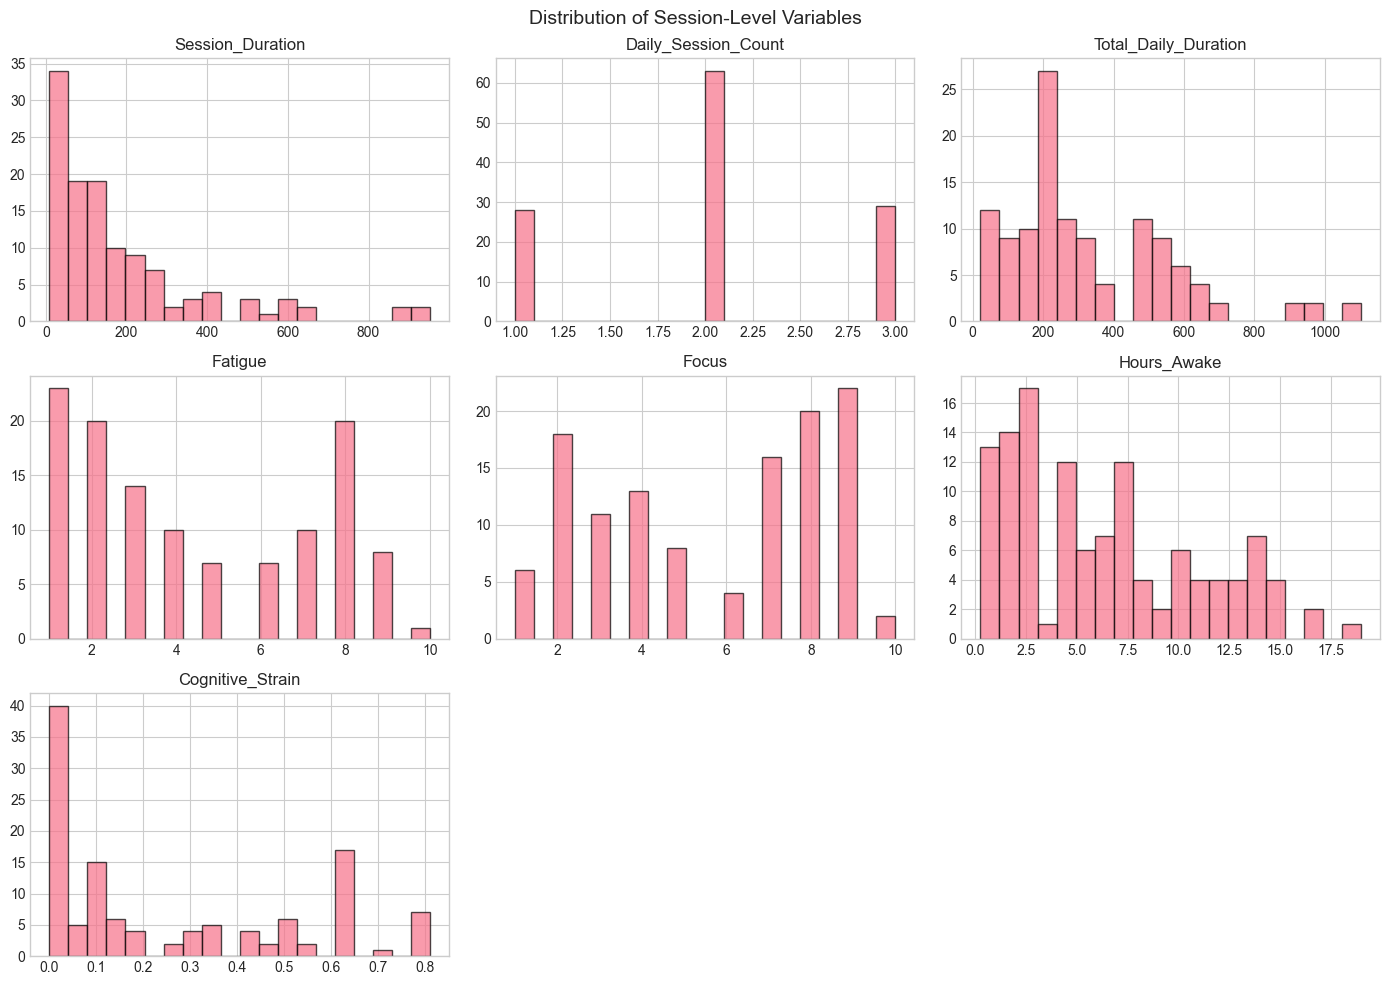

In [10]:
# Histograms for all numeric variables
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()
for i, col in enumerate(desc_cols):
    axes[i].hist(df_sessions[col].dropna(), bins=20, edgecolor='black', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
axes[7].axis('off')
axes[8].axis('off')
plt.suptitle('Distribution of Session-Level Variables', fontsize=14)
plt.tight_layout()
save_fig('03_histograms_distributions.png'); plt.show()

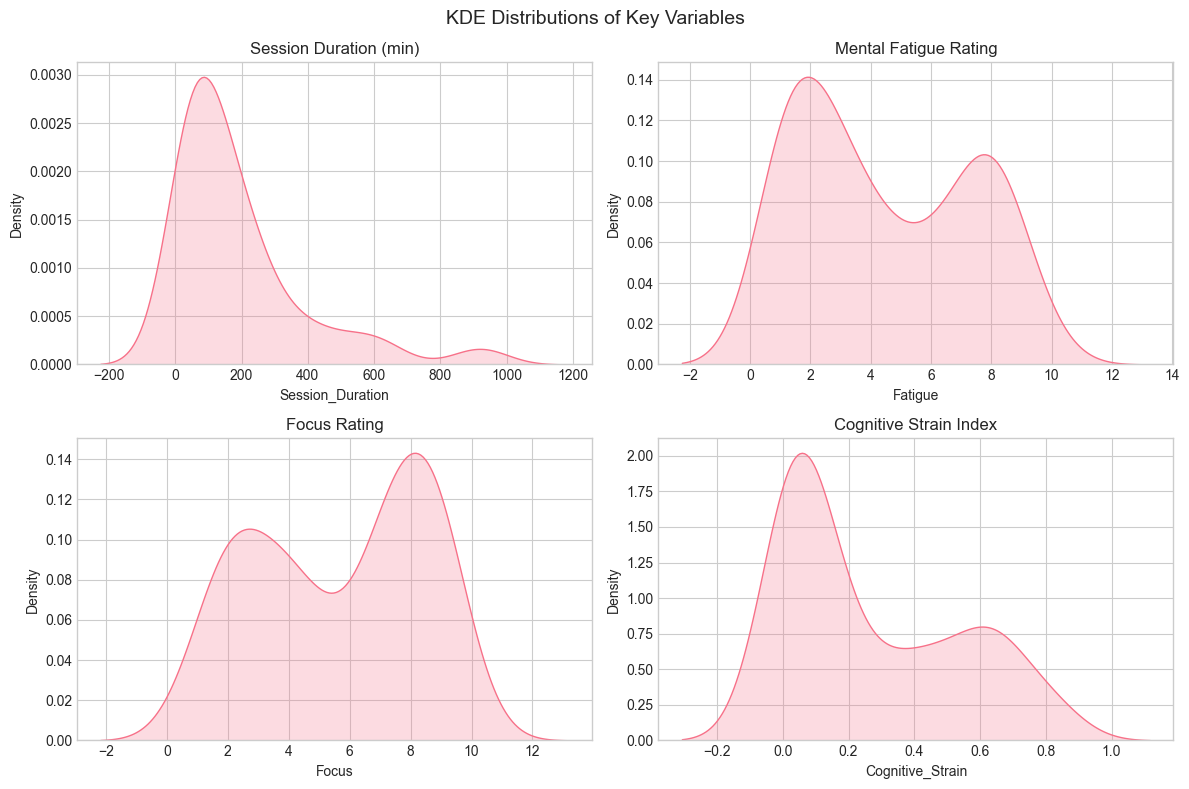

In [11]:
# KDE (Kernel Density Estimate) plots for key variables
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.kdeplot(data=df_sessions, x='Session_Duration', ax=axes[0,0], fill=True)
axes[0,0].set_title('Session Duration (min)')
sns.kdeplot(data=df_sessions, x='Fatigue', ax=axes[0,1], fill=True)
axes[0,1].set_title('Mental Fatigue Rating')
sns.kdeplot(data=df_sessions, x='Focus', ax=axes[1,0], fill=True)
axes[1,0].set_title('Focus Rating')
sns.kdeplot(data=df_sessions, x='Cognitive_Strain', ax=axes[1,1], fill=True)
axes[1,1].set_title('Cognitive Strain Index')
plt.suptitle('KDE Distributions of Key Variables', fontsize=14)
plt.tight_layout()
save_fig('04_kde_distributions.png'); plt.show()

### 5.2 Boxplots — Distribution by Variable

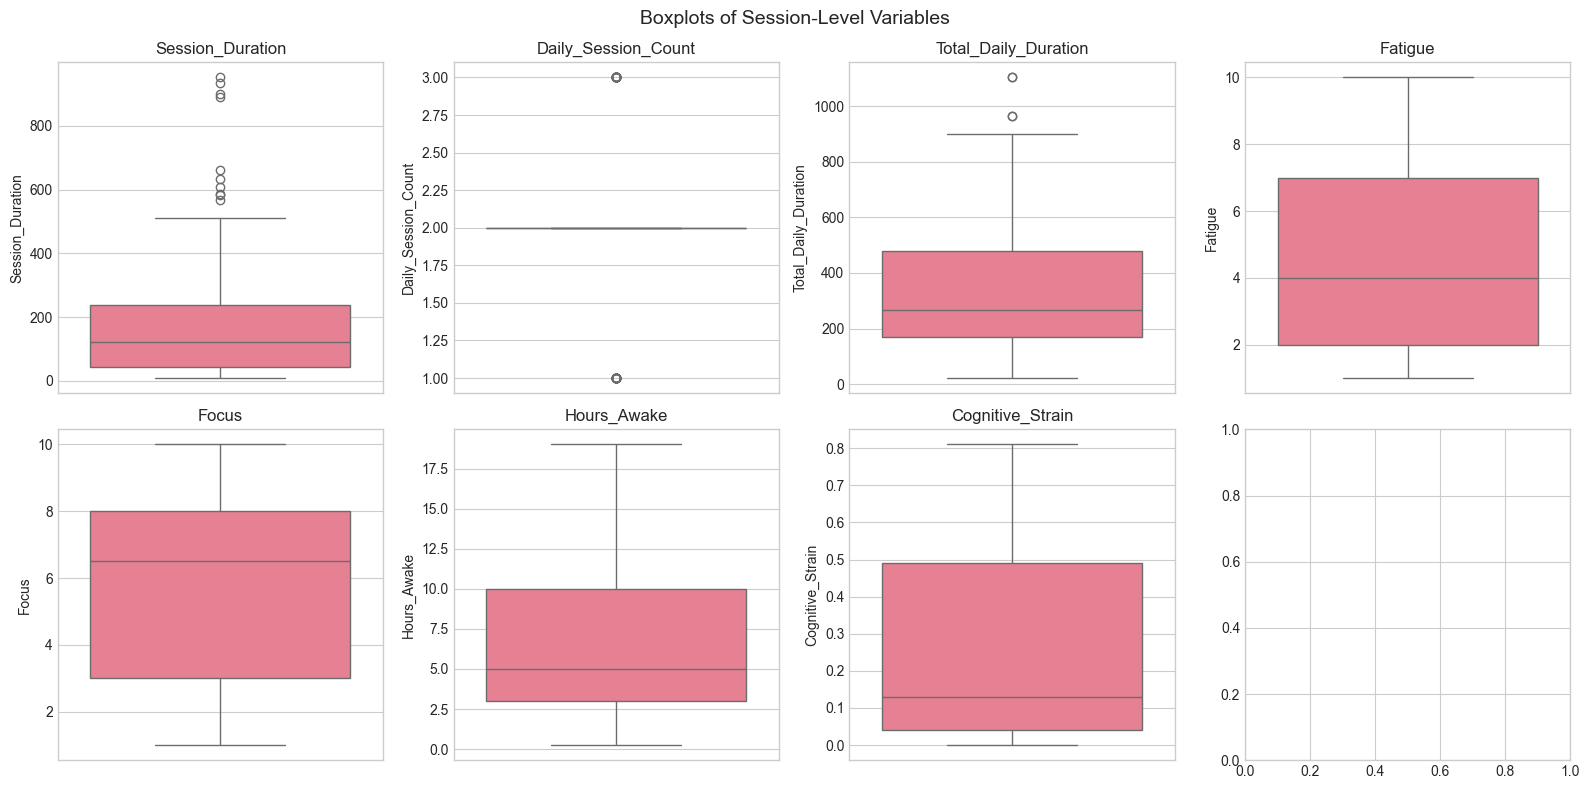

In [12]:
# Boxplots for numeric variables
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for i, col in enumerate(desc_cols):
    sns.boxplot(data=df_sessions, y=col, ax=axes[i])
    axes[i].set_title(col)
plt.suptitle('Boxplots of Session-Level Variables', fontsize=14)
plt.tight_layout()
save_fig('05_boxplots.png'); plt.show()

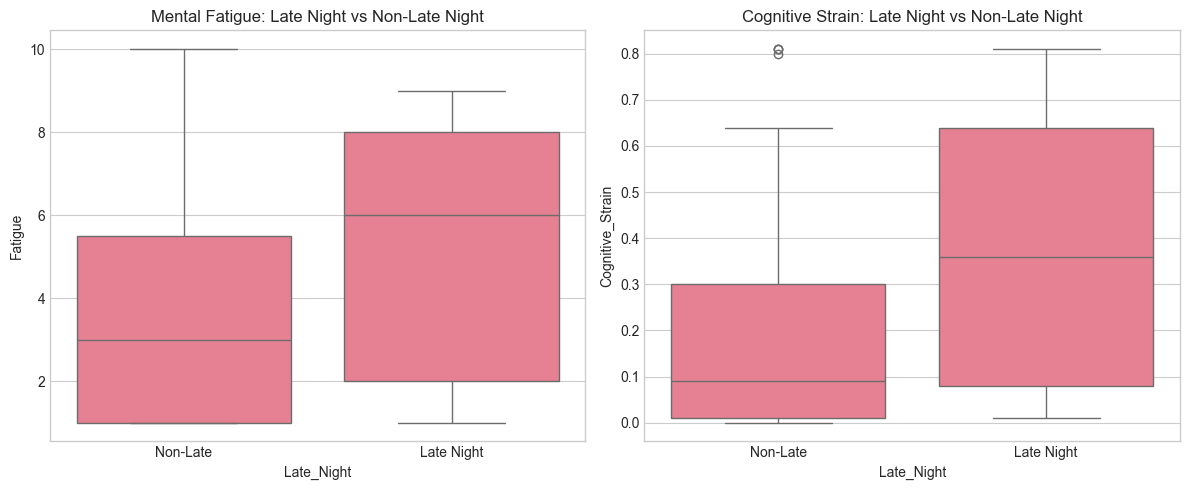

In [13]:
# Boxplot: Fatigue and Focus by Late Night vs Non-Late Night (Hypothesis 2)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=df_sessions, x='Late_Night', y='Fatigue', ax=axes[0])
axes[0].set_title('Mental Fatigue: Late Night vs Non-Late Night')
axes[0].set_xticklabels(['Non-Late', 'Late Night'])
sns.boxplot(data=df_sessions, x='Late_Night', y='Cognitive_Strain', ax=axes[1])
axes[1].set_title('Cognitive Strain: Late Night vs Non-Late Night')
axes[1].set_xticklabels(['Non-Late', 'Late Night'])
plt.tight_layout()
save_fig('06_boxplot_late_night_fatigue_strain.png'); plt.show()

### 5.3 Scatterplots — Relationships Between Variables (Hypothesis 1)

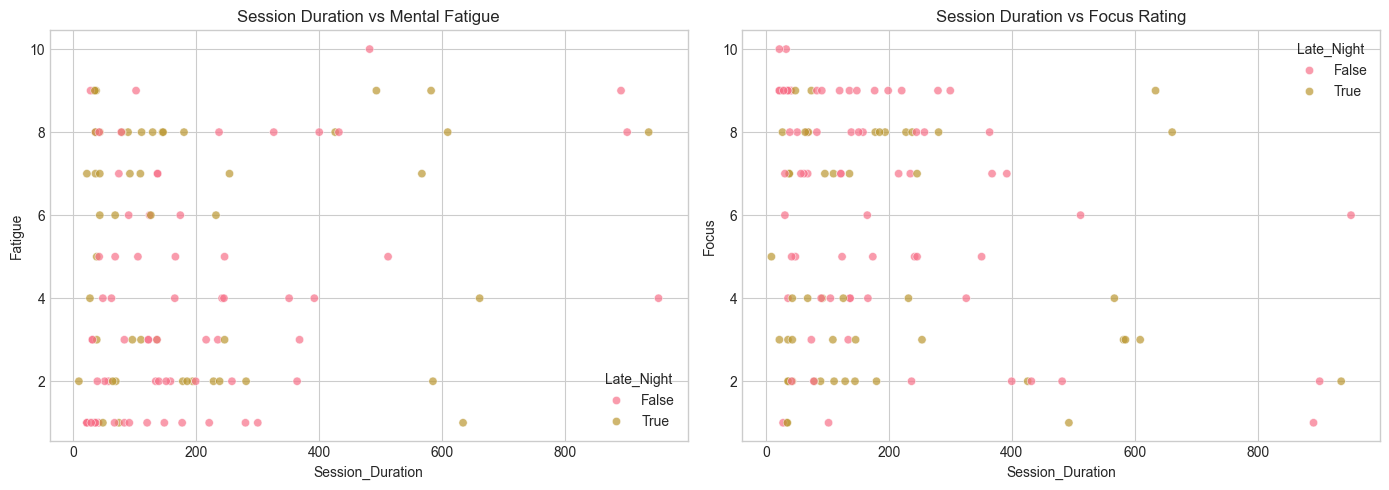

In [14]:
# Scatter: Session Duration vs Fatigue and Focus
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(data=df_sessions, x='Session_Duration', y='Fatigue', hue='Late_Night', alpha=0.7, ax=axes[0])
axes[0].set_title('Session Duration vs Mental Fatigue')
sns.scatterplot(data=df_sessions, x='Session_Duration', y='Focus', hue='Late_Night', alpha=0.7, ax=axes[1])
axes[1].set_title('Session Duration vs Focus Rating')
plt.tight_layout()
save_fig('07_scatter_duration_fatigue_focus.png'); plt.show()

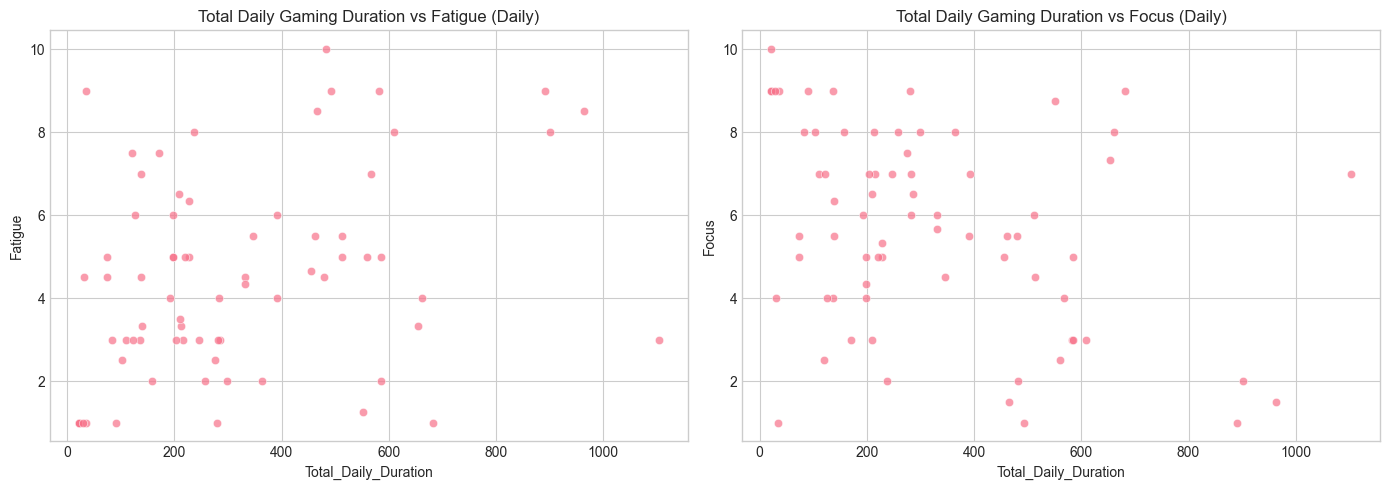

In [15]:
# Scatter: Total Daily Duration vs Fatigue and Focus (daily level)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(data=df_daily, x='Total_Daily_Duration', y='Fatigue', alpha=0.7, ax=axes[0])
axes[0].set_title('Total Daily Gaming Duration vs Fatigue (Daily)')
sns.scatterplot(data=df_daily, x='Total_Daily_Duration', y='Focus', alpha=0.7, ax=axes[1])
axes[1].set_title('Total Daily Gaming Duration vs Focus (Daily)')
plt.tight_layout()
save_fig('08_scatter_daily_duration.png'); plt.show()

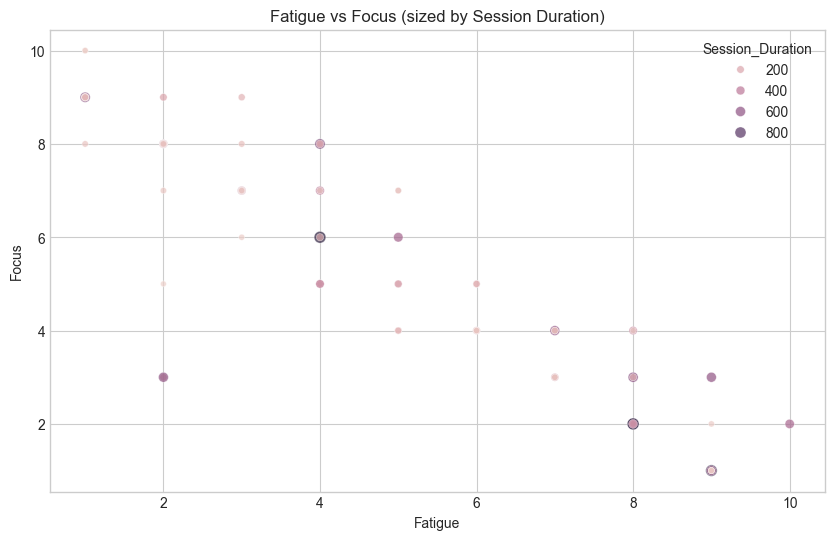

In [16]:
# Scatter: Fatigue vs Focus (inverse relationship expected)
sns.scatterplot(data=df_sessions, x='Fatigue', y='Focus', hue='Session_Duration', size='Session_Duration', alpha=0.7)
plt.title('Fatigue vs Focus (sized by Session Duration)')
save_fig('09_scatter_fatigue_focus.png'); plt.show()

### 5.4 Line Charts — Time Series (Daily Trends)

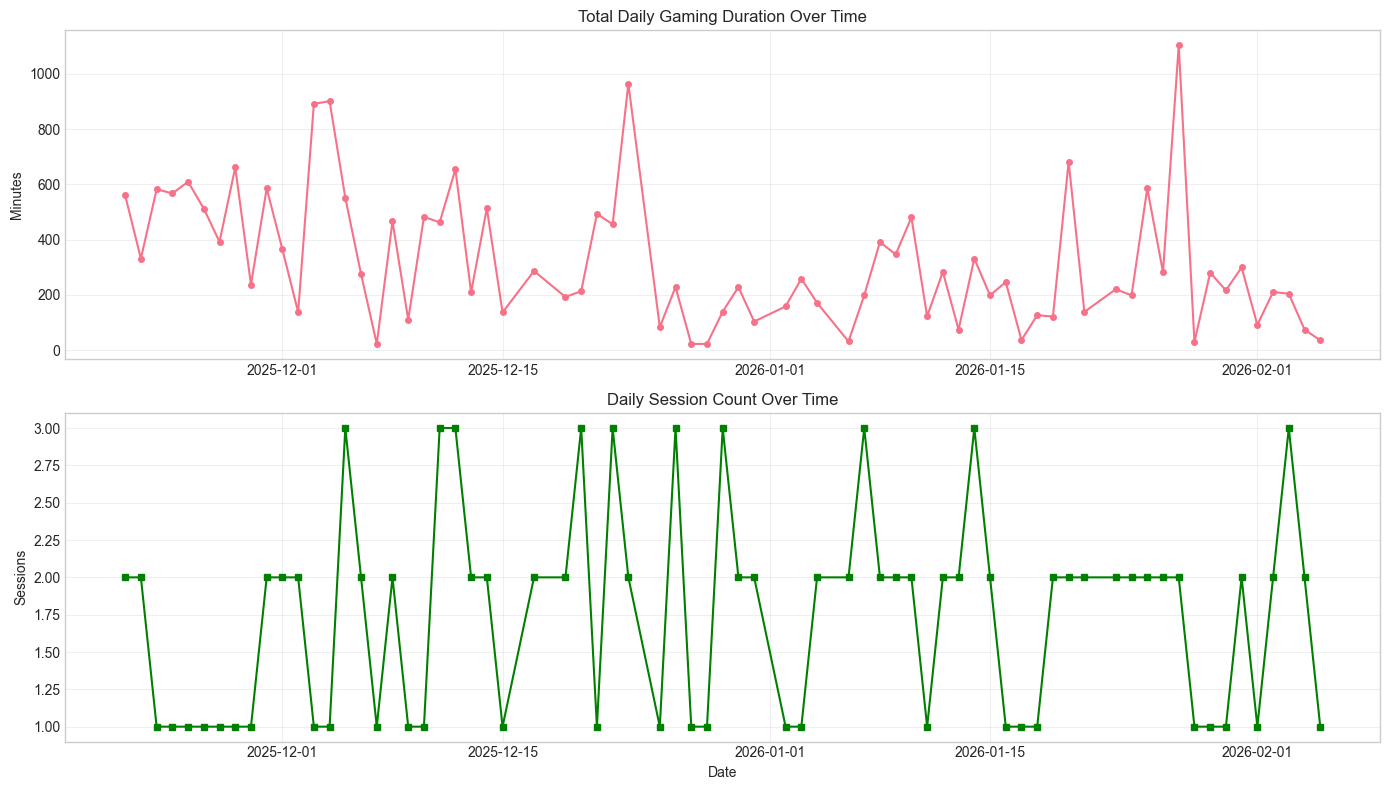

In [17]:
# Prepare daily time series
df_daily['Date_dt'] = pd.to_datetime(df_daily['Date'])
df_daily_sorted = df_daily.sort_values('Date_dt')

# Line chart: Total Daily Duration and Session Count over time
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
axes[0].plot(df_daily_sorted['Date_dt'], df_daily_sorted['Total_Daily_Duration'], marker='o', markersize=4)
axes[0].set_title('Total Daily Gaming Duration Over Time')
axes[0].set_ylabel('Minutes')
axes[0].grid(True, alpha=0.3)
axes[1].plot(df_daily_sorted['Date_dt'], df_daily_sorted['Daily_Session_Count'], marker='s', markersize=4, color='green')
axes[1].set_title('Daily Session Count Over Time')
axes[1].set_ylabel('Sessions')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
save_fig('10_line_daily_duration_sessions.png'); plt.show()

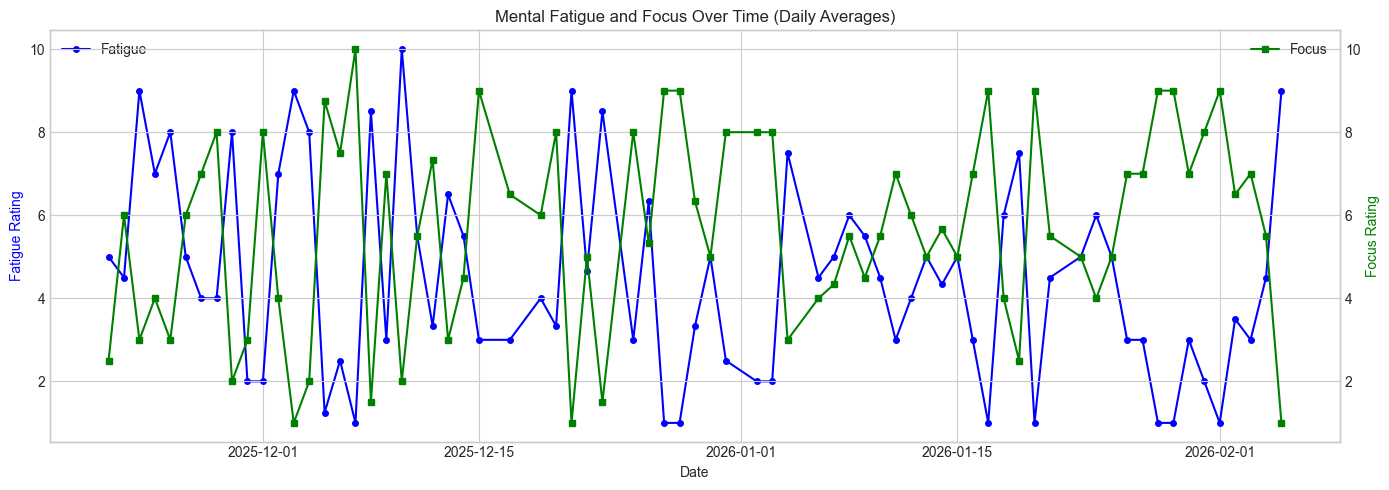

In [18]:
# Line chart: Fatigue and Focus ratings over time (daily averages)
fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()
ax1.plot(df_daily_sorted['Date_dt'], df_daily_sorted['Fatigue'], 'b-o', markersize=4, label='Fatigue')
ax2.plot(df_daily_sorted['Date_dt'], df_daily_sorted['Focus'], 'g-s', markersize=4, label='Focus')
ax1.set_ylabel('Fatigue Rating', color='b')
ax2.set_ylabel('Focus Rating', color='g')
ax1.set_xlabel('Date')
ax1.set_title('Mental Fatigue and Focus Over Time (Daily Averages)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
save_fig('11_line_fatigue_focus_time.png'); plt.show()

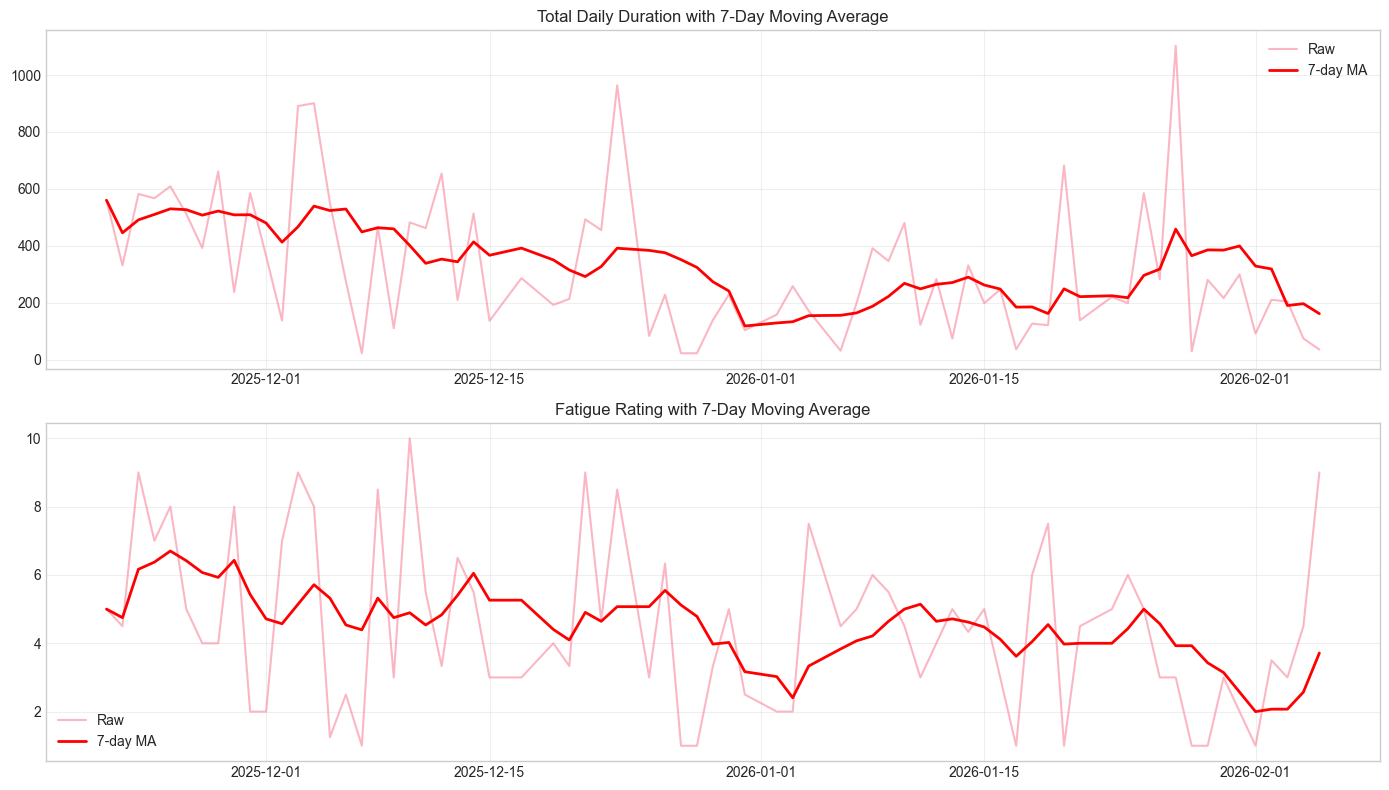

In [19]:
# Moving average (7-day) for trend smoothing
window = 7
df_daily_sorted['Duration_MA7'] = df_daily_sorted['Total_Daily_Duration'].rolling(window=window, min_periods=1).mean()
df_daily_sorted['Fatigue_MA7'] = df_daily_sorted['Fatigue'].rolling(window=window, min_periods=1).mean()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
axes[0].plot(df_daily_sorted['Date_dt'], df_daily_sorted['Total_Daily_Duration'], alpha=0.5, label='Raw')
axes[0].plot(df_daily_sorted['Date_dt'], df_daily_sorted['Duration_MA7'], 'r-', linewidth=2, label=f'{window}-day MA')
axes[0].set_title('Total Daily Duration with 7-Day Moving Average')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[1].plot(df_daily_sorted['Date_dt'], df_daily_sorted['Fatigue'], alpha=0.5, label='Raw')
axes[1].plot(df_daily_sorted['Date_dt'], df_daily_sorted['Fatigue_MA7'], 'r-', linewidth=2, label=f'{window}-day MA')
axes[1].set_title('Fatigue Rating with 7-Day Moving Average')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
save_fig('12_line_moving_average.png'); plt.show()

### 5.5 Correlation Heatmap

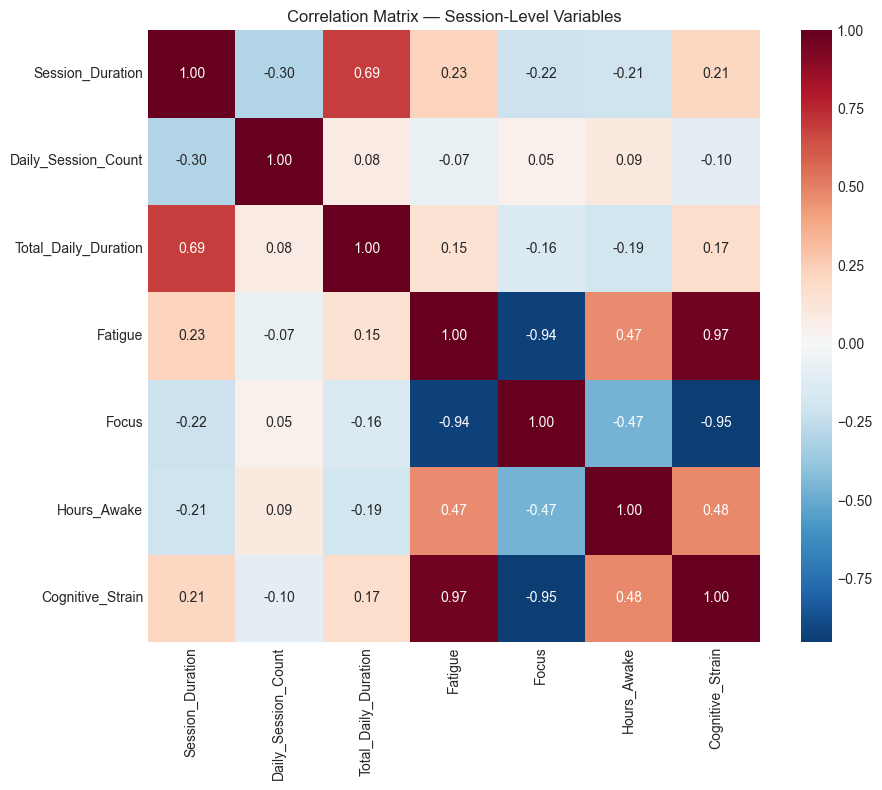

In [20]:
# Correlation matrix
corr_cols = ['Session_Duration', 'Daily_Session_Count', 'Total_Daily_Duration', 'Fatigue', 'Focus', 'Hours_Awake', 'Cognitive_Strain']
corr_matrix = df_sessions[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f', square=True)
plt.title('Correlation Matrix — Session-Level Variables')
plt.tight_layout()
save_fig('13_correlation_heatmap.png'); plt.show()

### 5.6 Pair Plot (Key Variables)

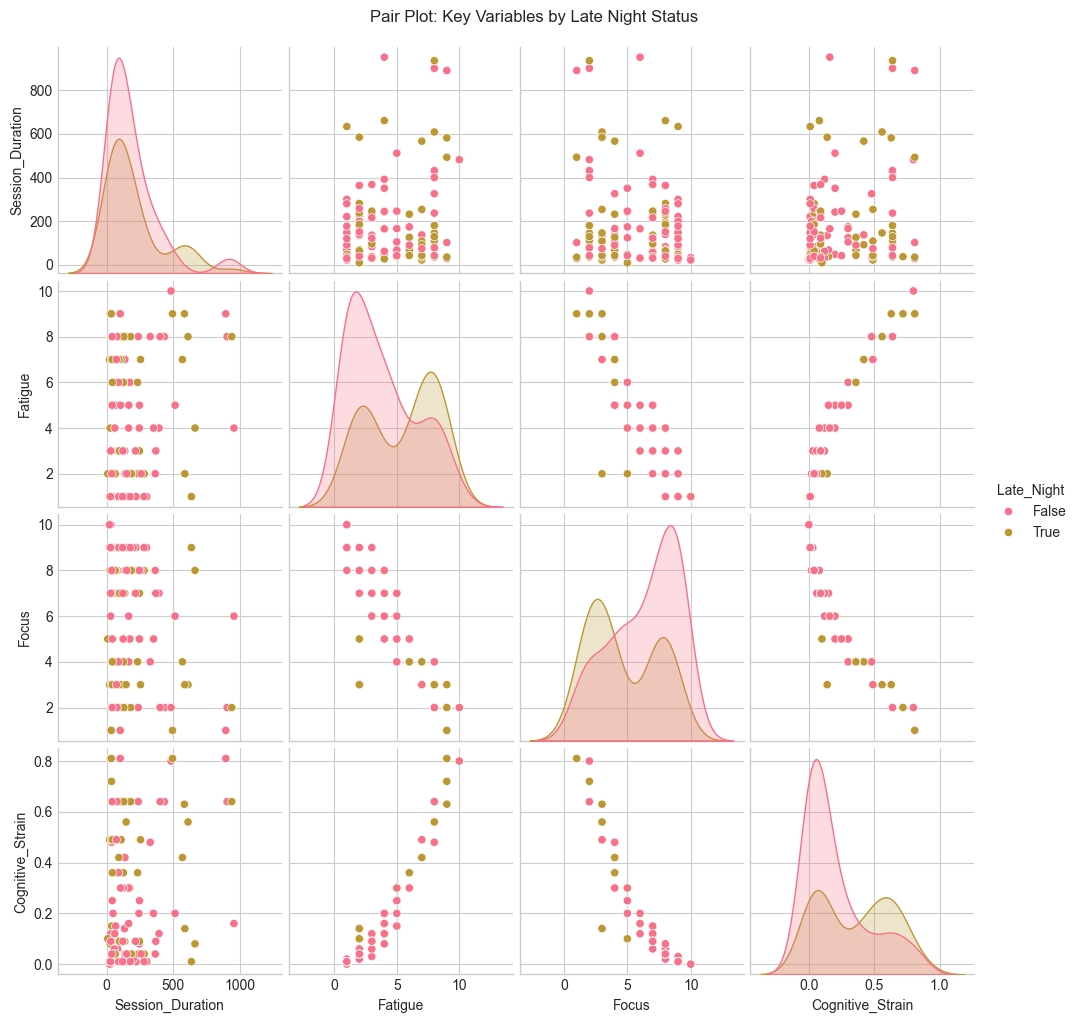

In [21]:
# Pair plot for core variables (sample if large)
pair_cols = ['Session_Duration', 'Fatigue', 'Focus', 'Cognitive_Strain']
g = sns.pairplot(df_sessions[pair_cols + ['Late_Night']], hue='Late_Night', diag_kind='kde')
g.fig.suptitle('Pair Plot: Key Variables by Late Night Status', y=1.02)
g.savefig(os.path.join(RESULTS_DIR, '14_pairplot.png'), dpi=150, bbox_inches='tight')
plt.show()

### 5.7 Violin Plots and Session Timing Analysis

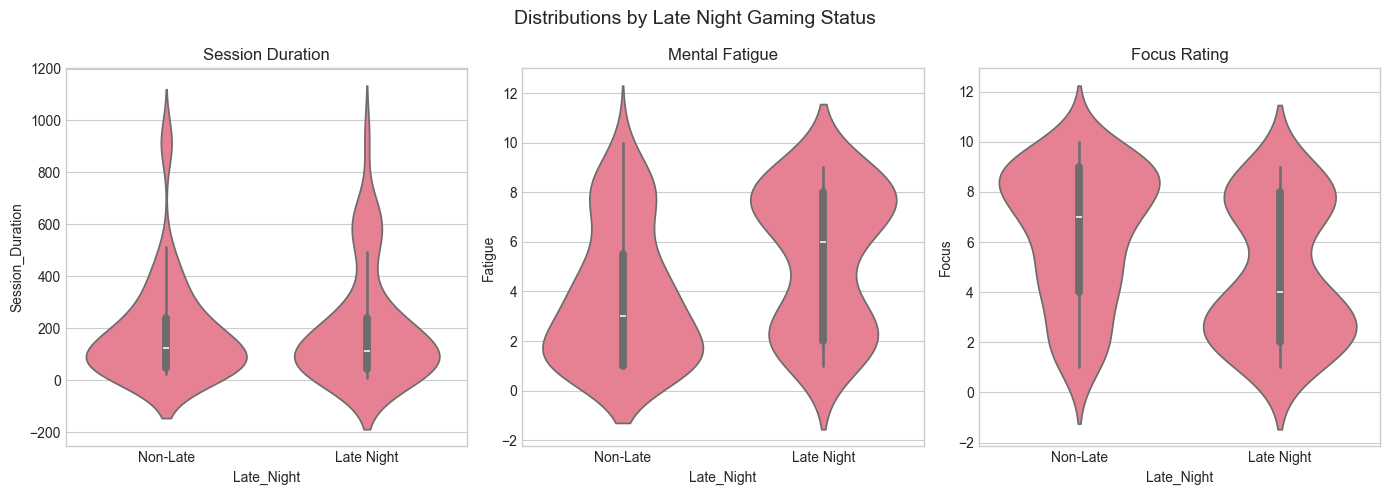

In [22]:
# Violin plots: Session Duration, Fatigue, Focus by Late Night
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
sns.violinplot(data=df_sessions, x='Late_Night', y='Session_Duration', ax=axes[0])
axes[0].set_xticklabels(['Non-Late', 'Late Night'])
axes[0].set_title('Session Duration')
sns.violinplot(data=df_sessions, x='Late_Night', y='Fatigue', ax=axes[1])
axes[1].set_xticklabels(['Non-Late', 'Late Night'])
axes[1].set_title('Mental Fatigue')
sns.violinplot(data=df_sessions, x='Late_Night', y='Focus', ax=axes[2])
axes[2].set_xticklabels(['Non-Late', 'Late Night'])
axes[2].set_title('Focus Rating')
plt.suptitle('Distributions by Late Night Gaming Status', fontsize=14)
plt.tight_layout()
save_fig('15_violin_late_night.png'); plt.show()

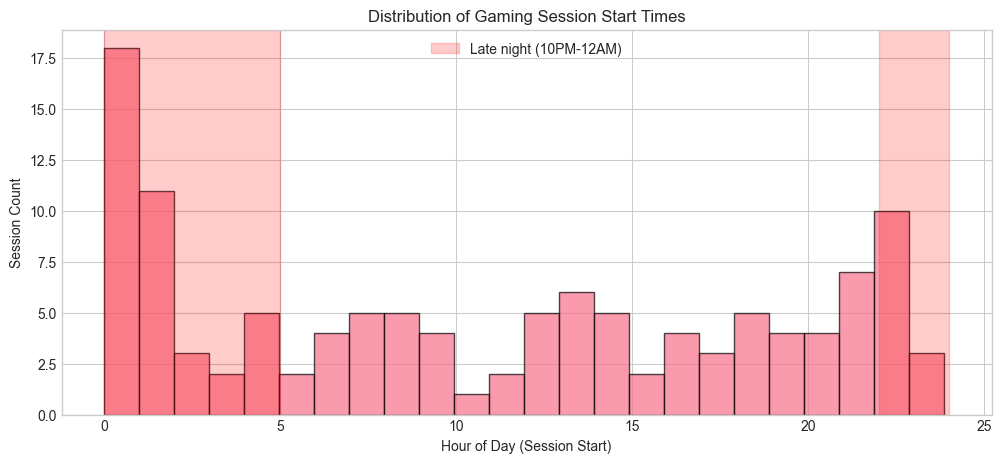

In [23]:
# Distribution of session start hour (when do they play?)
plt.figure(figsize=(12, 5))
plt.hist(df_sessions['Start_Hour'], bins=24, edgecolor='black', alpha=0.7)
plt.axvspan(22, 24, alpha=0.2, color='red', label='Late night (10PM-12AM)')
plt.axvspan(0, 5, alpha=0.2, color='red')
plt.xlabel('Hour of Day (Session Start)')
plt.ylabel('Session Count')
plt.title('Distribution of Gaming Session Start Times')
plt.legend()
save_fig('16_hist_session_start_hour.png'); plt.show()

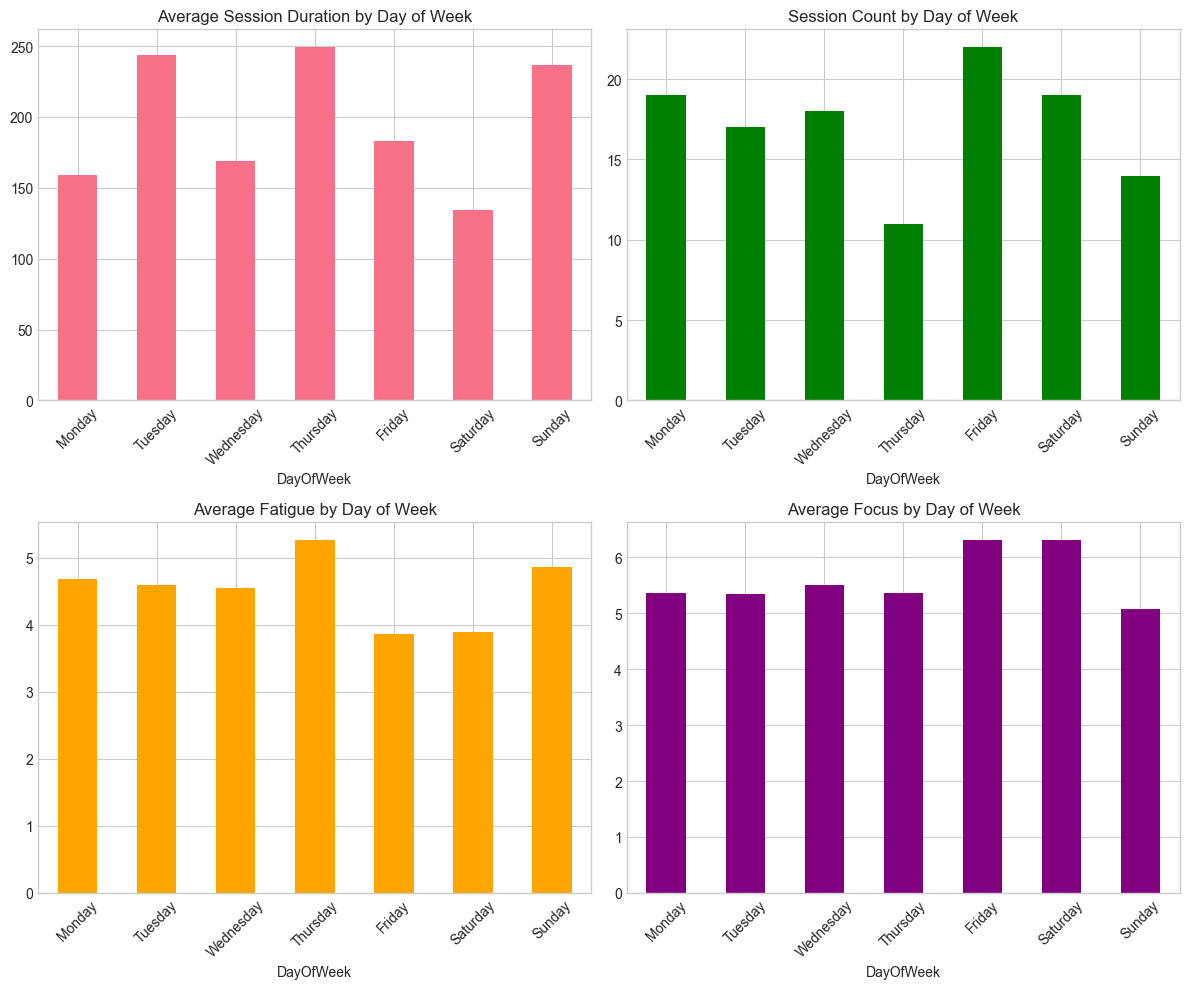

In [24]:
# Bar chart: Day of week patterns (seasonality)
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_agg = df_sessions.groupby('DayOfWeek').agg(
    Avg_Duration=('Session_Duration', 'mean'),
    Session_Count=('Session_Duration', 'count'),
    Avg_Fatigue=('Fatigue', 'mean'),
    Avg_Focus=('Focus', 'mean')
)
dow_agg = dow_agg.reindex([d for d in dow_order if d in dow_agg.index])

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
dow_agg['Avg_Duration'].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Average Session Duration by Day of Week')
axes[0,0].tick_params(axis='x', rotation=45)
dow_agg['Session_Count'].plot(kind='bar', ax=axes[0,1], color='green')
axes[0,1].set_title('Session Count by Day of Week')
axes[0,1].tick_params(axis='x', rotation=45)
dow_agg['Avg_Fatigue'].plot(kind='bar', ax=axes[1,0], color='orange')
axes[1,0].set_title('Average Fatigue by Day of Week')
axes[1,0].tick_params(axis='x', rotation=45)
dow_agg['Avg_Focus'].plot(kind='bar', ax=axes[1,1], color='purple')
axes[1,1].set_title('Average Focus by Day of Week')
axes[1,1].tick_params(axis='x', rotation=45)
plt.tight_layout()
save_fig('17_bar_day_of_week.png'); plt.show()

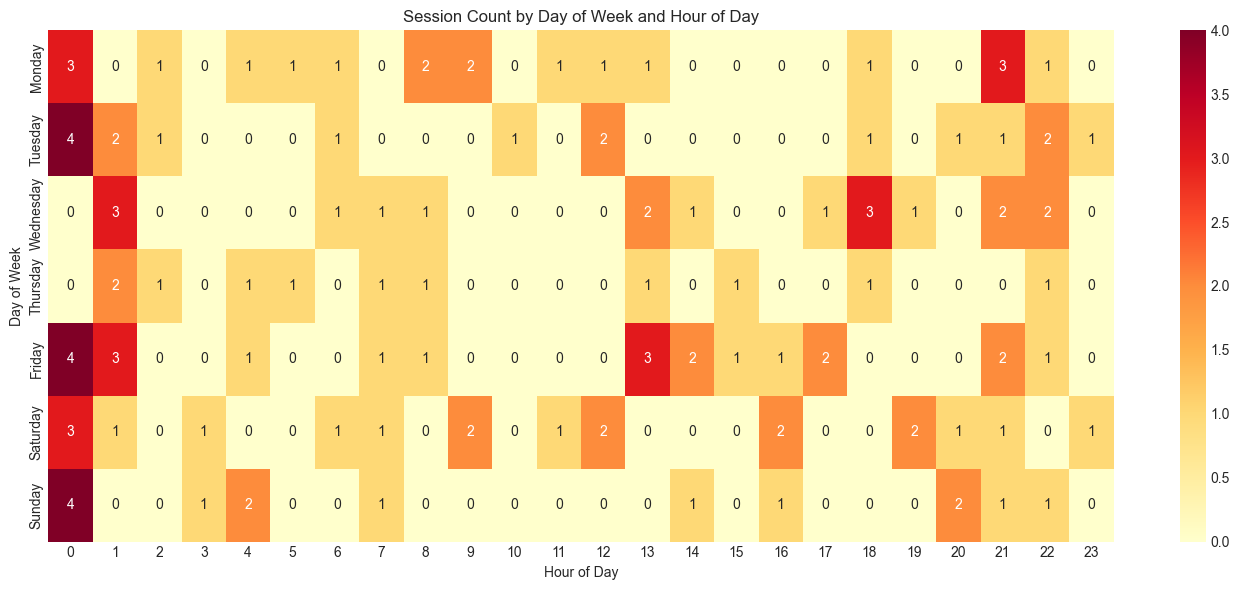

In [25]:
# Heatmap: Session count by Day of Week and Hour of Day
df_heat = df_sessions.copy()
df_heat['Hour'] = df_heat['Start_Hour'].astype(int)
pivot = pd.crosstab(df_heat['DayOfWeek'], df_heat['Hour'])
# Reorder rows by day of week
pivot = pivot.reindex([d for d in dow_order if d in pivot.index])
plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='d')
plt.title('Session Count by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
save_fig('18_heatmap_day_hour.png'); plt.show()

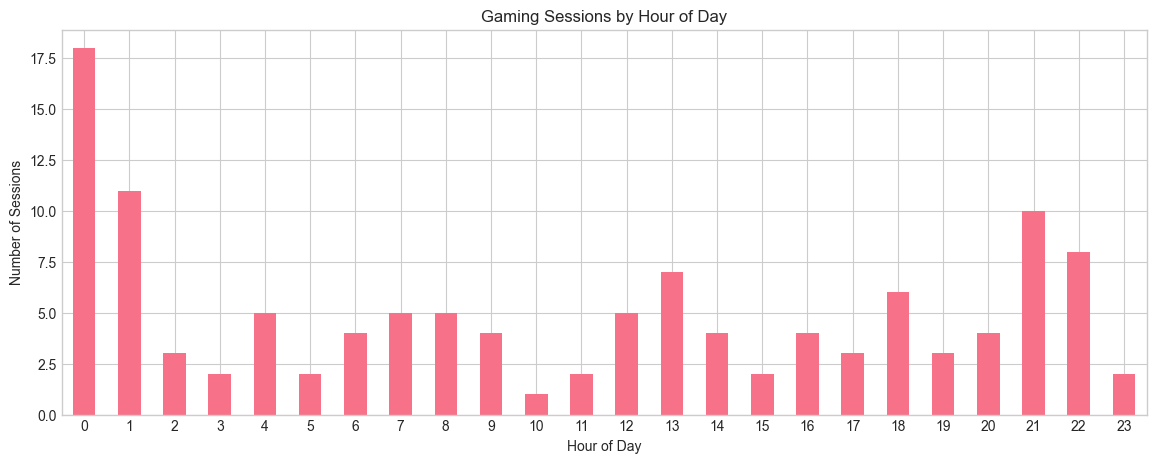

In [26]:
# Bar chart: Session count by hour of day
hour_counts = df_sessions.groupby(df_sessions['Start_Hour'].astype(int)).size()
plt.figure(figsize=(14, 5))
hour_counts.plot(kind='bar')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sessions')
plt.title('Gaming Sessions by Hour of Day')
plt.xticks(rotation=0)
save_fig('19_bar_sessions_by_hour.png'); plt.show()

### 5.8 Additional Visualizations

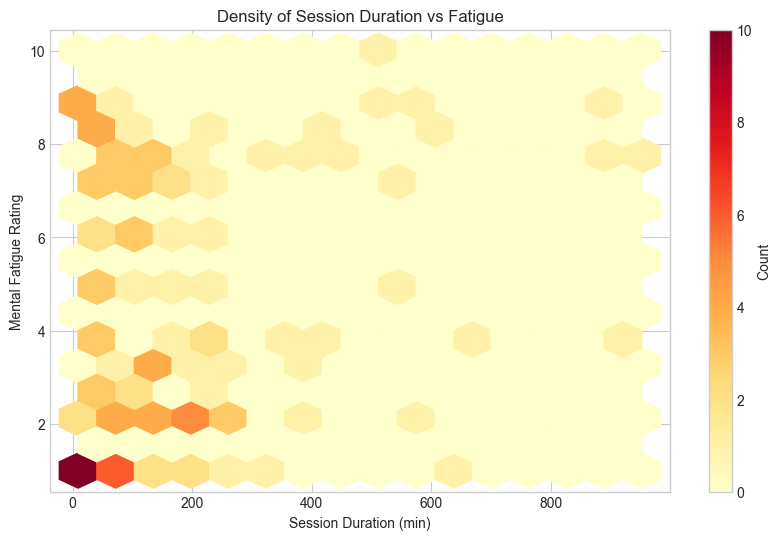

In [27]:
# Hexbin: Session Duration vs Fatigue (density)
plt.figure(figsize=(10, 6))
plt.hexbin(df_sessions['Session_Duration'], df_sessions['Fatigue'], gridsize=15, cmap='YlOrRd')
plt.colorbar(label='Count')
plt.xlabel('Session Duration (min)')
plt.ylabel('Mental Fatigue Rating')
plt.title('Density of Session Duration vs Fatigue')
save_fig('20_hexbin_duration_fatigue.png'); plt.show()

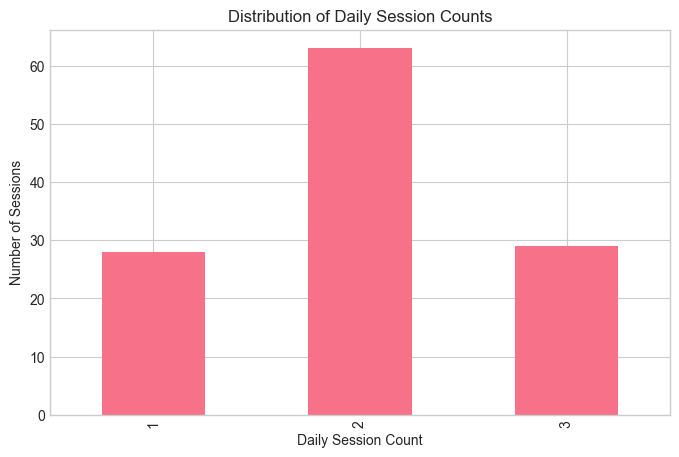

In [28]:
# Stacked bar: Daily Session Count distribution
session_count_dist = df_sessions.groupby('Daily_Session_Count').size()
plt.figure(figsize=(8, 5))
session_count_dist.plot(kind='bar')
plt.xlabel('Daily Session Count')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Daily Session Counts')
save_fig('21_bar_daily_session_count.png'); plt.show()

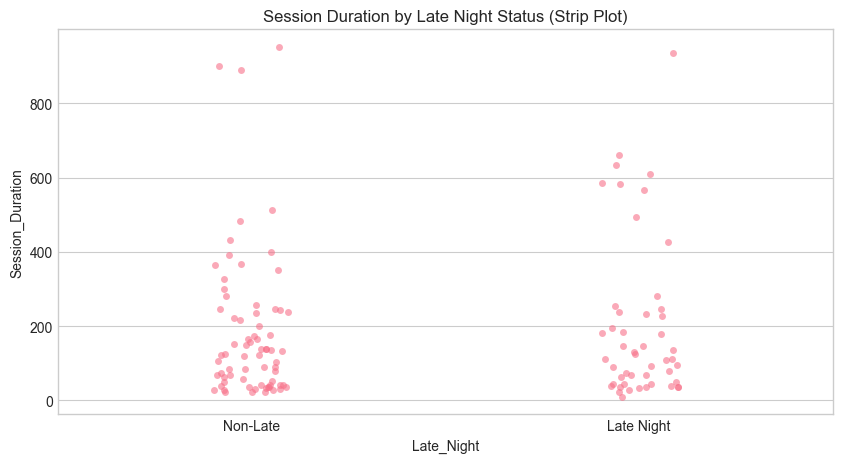

In [29]:
# Strip plot: Session Duration by Late Night (jittered)
plt.figure(figsize=(10, 5))
sns.stripplot(data=df_sessions, x='Late_Night', y='Session_Duration', jitter=True, alpha=0.6)
ax = plt.gca(); ax.set_xticklabels(['Non-Late', 'Late Night'])
plt.title('Session Duration by Late Night Status (Strip Plot)')
save_fig('22_strip_plot_late_night.png'); plt.show()

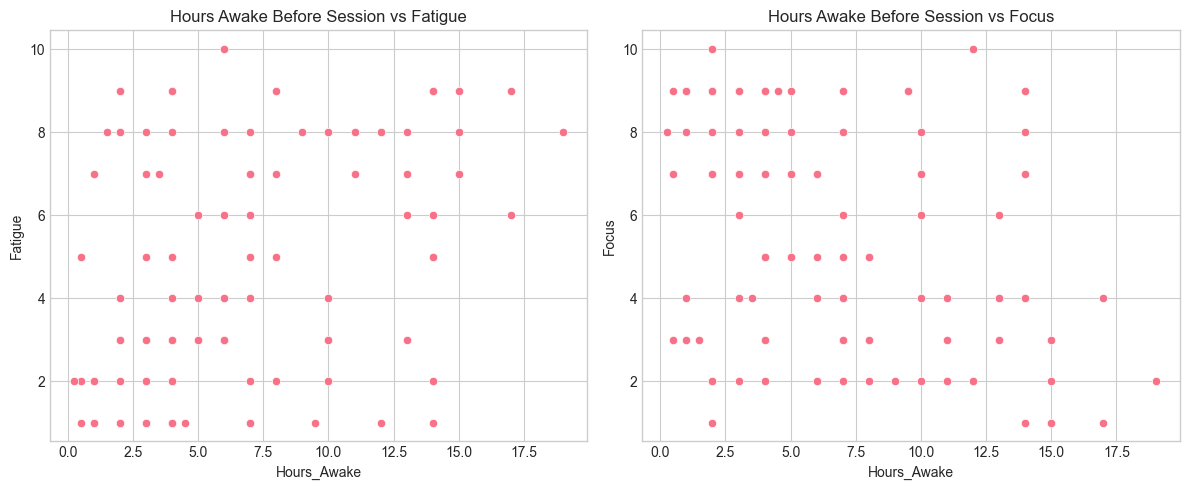

In [30]:
# Hours Awake vs Fatigue/Focus
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=df_sessions, x='Hours_Awake', y='Fatigue', ax=axes[0])
axes[0].set_title('Hours Awake Before Session vs Fatigue')
sns.scatterplot(data=df_sessions, x='Hours_Awake', y='Focus', ax=axes[1])
axes[1].set_title('Hours Awake Before Session vs Focus')
plt.tight_layout()
save_fig('23_scatter_hours_awake.png'); plt.show()

---
## 6. Statistical Tests

**Purpose:** Test hypotheses with appropriate statistical tests, check assumptions, report p-values.

### 6.1 Normality Check (Assumption for parametric tests)

In [31]:
# Shapiro-Wilk normality test for key variables
with open(os.path.join(RESULTS_DIR, '30_shapiro_normality.txt'), 'w') as f:
    for col in ['Session_Duration', 'Fatigue', 'Focus', 'Cognitive_Strain']:
        stat, p = shapiro(df_sessions[col].dropna())
        line = f"{col}: Shapiro stat={stat:.4f}, p={p:.4f} {'(Normal)' if p > 0.05 else '(Non-normal)'}\n"
        f.write(line)
        print(line.strip())

Session_Duration: Shapiro stat=0.7565, p=0.0000 (Non-normal)
Fatigue: Shapiro stat=0.8847, p=0.0000 (Non-normal)
Focus: Shapiro stat=0.8961, p=0.0000 (Non-normal)
Cognitive_Strain: Shapiro stat=0.8333, p=0.0000 (Non-normal)


### 6.2 Pearson Correlation with Significance (Hypothesis 1)

**H1:** Longer and more frequent gameplay is associated with higher fatigue and lower focus.

In [32]:
# Pearson correlation: Session Duration vs Fatigue, Focus
r_dur_fat, p_dur_fat = pearsonr(df_sessions['Session_Duration'], df_sessions['Fatigue'])
r_dur_foc, p_dur_foc = pearsonr(df_sessions['Session_Duration'], df_sessions['Focus'])
r_daily_fat, p_daily_fat = pearsonr(df_daily['Total_Daily_Duration'], df_daily['Fatigue'])
r_daily_foc, p_daily_foc = pearsonr(df_daily['Total_Daily_Duration'], df_daily['Focus'])

print("Session Duration vs Fatigue:  r = {:.3f}, p = {:.4f} {}".format(r_dur_fat, p_dur_fat, "**" if p_dur_fat < 0.05 else ""))
print("Session Duration vs Focus:    r = {:.3f}, p = {:.4f} {}".format(r_dur_foc, p_dur_foc, "**" if p_dur_foc < 0.05 else ""))
print("Total Daily Duration vs Fatigue: r = {:.3f}, p = {:.4f} {}".format(r_daily_fat, p_daily_fat, "**" if p_daily_fat < 0.05 else ""))
print("Total Daily Duration vs Focus:   r = {:.3f}, p = {:.4f} {}".format(r_daily_foc, p_daily_foc, "**" if p_daily_foc < 0.05 else ""))
print("\n** = p < 0.05 (statistically significant)")
with open(os.path.join(RESULTS_DIR, '31_pearson_correlation.txt'), 'w') as f:
    f.write('Session Duration vs Fatigue:  r = {:.3f}, p = {:.4f}\n'.format(r_dur_fat, p_dur_fat))
    f.write('Session Duration vs Focus:    r = {:.3f}, p = {:.4f}\n'.format(r_dur_foc, p_dur_foc))
    f.write('Total Daily Duration vs Fatigue: r = {:.3f}, p = {:.4f}\n'.format(r_daily_fat, p_daily_fat))
    f.write('Total Daily Duration vs Focus:   r = {:.3f}, p = {:.4f}\n'.format(r_daily_foc, p_daily_foc))

Session Duration vs Fatigue:  r = 0.225, p = 0.0133 **
Session Duration vs Focus:    r = -0.217, p = 0.0175 **
Total Daily Duration vs Fatigue: r = 0.336, p = 0.0041 **
Total Daily Duration vs Focus:   r = -0.341, p = 0.0036 **

** = p < 0.05 (statistically significant)


In [33]:
# Spearman correlation (robust to non-normality)
r_s, p_s = spearmanr(df_sessions['Session_Duration'], df_sessions['Fatigue'])
print("Spearman: Session Duration vs Fatigue: r = {:.3f}, p = {:.4f}".format(r_s, p_s))
with open(os.path.join(RESULTS_DIR, '32_spearman.txt'), 'w') as f:
    f.write('Spearman Session Duration vs Fatigue: r = {:.3f}, p = {:.4f}\n'.format(r_s, p_s))

Spearman: Session Duration vs Fatigue: r = 0.179, p = 0.0500


### 6.3 Independent Samples t-Test (Hypothesis 2)

**H2:** Late-night gaming sessions show higher cognitive strain than non-late sessions.

In [34]:
# Split by Late Night
late = df_sessions[df_sessions['Late_Night']]['Cognitive_Strain']
non_late = df_sessions[~df_sessions['Late_Night']]['Cognitive_Strain']

# Levene's test for equality of variances
lev_stat, lev_p = levene(late, non_late)
print("Levene test (equal variance): stat = {:.3f}, p = {:.4f}".format(lev_stat, lev_p))

# Independent t-test
t_stat, p_val = ttest_ind(late, non_late)
print("\nt-test: Cognitive Strain (Late vs Non-Late)")
print("  Late Night mean:   {:.4f} (n={})".format(late.mean(), len(late)))
print("  Non-Late mean:    {:.4f} (n={})".format(non_late.mean(), len(non_late)))
print("  t-statistic:      {:.3f}".format(t_stat))
print("  p-value:          {:.4f} {}".format(p_val, "(Significant)" if p_val < 0.05 else "(Not significant)"))
with open(os.path.join(RESULTS_DIR, '33_ttest_late_night.txt'), 'w') as f:
    f.write('Levene: stat={:.3f}, p={:.4f}\n'.format(lev_stat, lev_p))
    f.write('t-test: t={:.3f}, p={:.4f}\nLate mean={:.4f}, Non-Late mean={:.4f}\n'.format(t_stat, p_val, late.mean(), non_late.mean()))

Levene test (equal variance): stat = 5.264, p = 0.0235

t-test: Cognitive Strain (Late vs Non-Late)
  Late Night mean:   0.3547 (n=49)
  Non-Late mean:    0.2035 (n=71)
  t-statistic:      3.166
  p-value:          0.0020 (Significant)


In [35]:
# t-test for Fatigue and Focus by Late Night
for var in ['Fatigue', 'Focus']:
    late_v = df_sessions[df_sessions['Late_Night']][var]
    non_v = df_sessions[~df_sessions['Late_Night']][var]
    t, p = ttest_ind(late_v, non_v)
    print(f"{var}: Late mean={late_v.mean():.2f}, Non-Late mean={non_v.mean():.2f}, t={t:.3f}, p={p:.4f}")

Fatigue: Late mean=5.41, Non-Late mean=3.79, t=3.190, p=0.0018
Focus: Late mean=4.69, Non-Late mean=6.35, t=-3.365, p=0.0010


---
## 7. Correlation Analysis (Detailed)

Full correlation matrix with p-values for significance.

In [36]:
# Correlation matrix with p-values
def corr_with_pval(df, cols):
    n = len(cols)
    r_matrix = np.zeros((n, n))
    p_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            r, p = pearsonr(df[cols[i]].dropna(), df[cols[j]].dropna())
            r_matrix[i, j] = r
            p_matrix[i, j] = p
    return pd.DataFrame(r_matrix, index=cols, columns=cols), pd.DataFrame(p_matrix, index=cols, columns=cols)

r_df, p_df = corr_with_pval(df_sessions, corr_cols)
print("Correlation coefficients:")
print(r_df.round(3).to_string())
print("\nP-values:")
print(p_df.round(4).to_string())
with open(os.path.join(RESULTS_DIR, '34_correlation_matrix.txt'), 'w') as f:
    f.write('Correlation coefficients:\n' + r_df.round(3).to_string() + '\n\nP-values:\n' + p_df.round(4).to_string())

Correlation coefficients:
                      Session_Duration  Daily_Session_Count  Total_Daily_Duration  Fatigue  Focus  Hours_Awake  Cognitive_Strain
Session_Duration                 1.000               -0.302                 0.692    0.225 -0.217       -0.208             0.214
Daily_Session_Count             -0.302                1.000                 0.080   -0.070  0.050        0.095            -0.100
Total_Daily_Duration             0.692                0.080                 1.000    0.150 -0.156       -0.190             0.173
Fatigue                          0.225               -0.070                 0.150    1.000 -0.935        0.474             0.967
Focus                           -0.217                0.050                -0.156   -0.935  1.000       -0.466            -0.953
Hours_Awake                     -0.208                0.095                -0.190    0.474 -0.466        1.000             0.479
Cognitive_Strain                 0.214               -0.100            

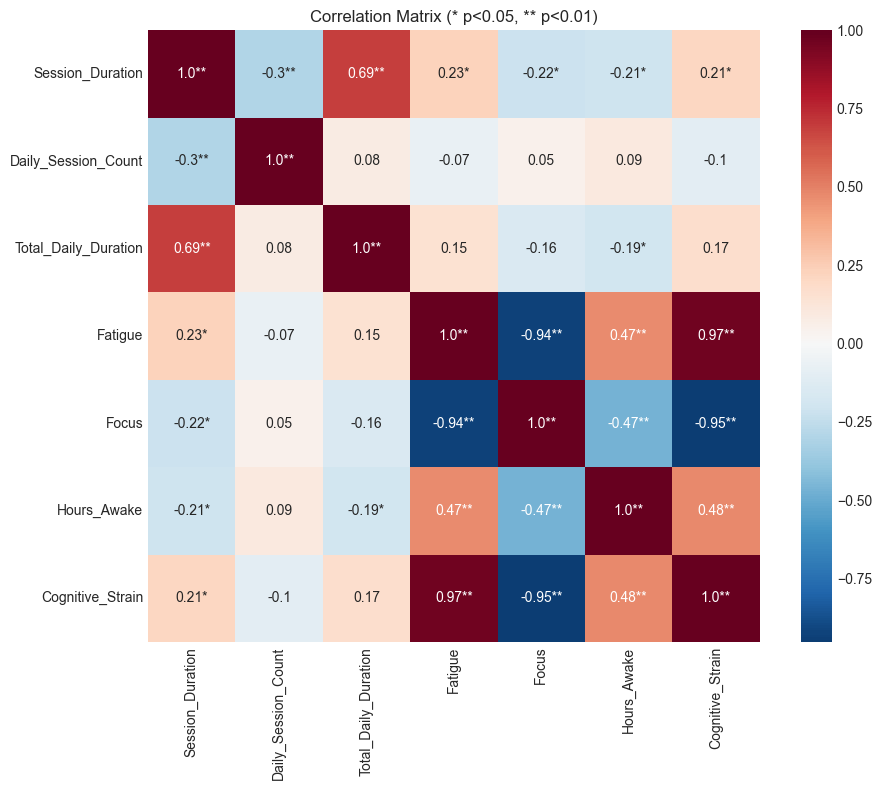

In [37]:
# Annotated heatmap with significance stars
annot = r_df.round(2).astype(str)
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        if p_df.iloc[i, j] < 0.01:
            annot.iloc[i, j] += '**'
        elif p_df.iloc[i, j] < 0.05:
            annot.iloc[i, j] += '*'

plt.figure(figsize=(10, 8))
sns.heatmap(r_df, annot=annot, cmap='RdBu_r', center=0, fmt='', square=True)
plt.title('Correlation Matrix (* p<0.05, ** p<0.01)')
plt.tight_layout()
save_fig('24_correlation_annotated.png'); plt.show()

---
## 8. Clustering Analysis — Gameplay Behavior Profiles

**Objective:** Detect distinct gameplay behavior profiles that may indicate addiction-related or maladaptive patterns.

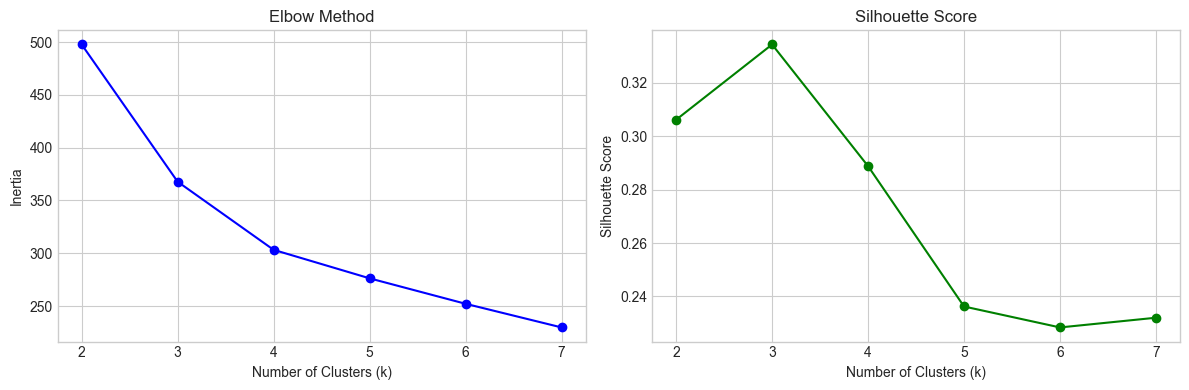

In [38]:
# Prepare features for clustering
cluster_vars = ['Session_Duration', 'Daily_Session_Count', 'Total_Daily_Duration', 'Fatigue', 'Focus', 'Hours_Awake']
X_cluster = df_sessions[cluster_vars].fillna(df_sessions[cluster_vars].median())
X_scaled = StandardScaler().fit_transform(X_cluster)

# Elbow method for optimal k
inertias = []
silhouettes = []
K_range = range(2, 8)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, km.labels_))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(list(K_range), inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[1].plot(list(K_range), silhouettes, 'go-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score')
plt.tight_layout()
save_fig('25_elbow_silhouette.png'); plt.show()

In [39]:
# Fit K-Means with chosen k (e.g., 3 or 4 based on elbow/silhouette)
k_opt = 4
km = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
df_sessions['Cluster'] = km.fit_predict(X_scaled)

# Cluster profiles (mean values per cluster)
cluster_profiles = df_sessions.groupby('Cluster')[cluster_vars].mean()
cluster_profiles.round(2).to_csv(os.path.join(RESULTS_DIR, '35_cluster_profiles.csv'))
print("Cluster Profiles (mean values):")
print(cluster_profiles.round(2))

Cluster Profiles (mean values):
         Session_Duration  Daily_Session_Count  Total_Daily_Duration  Fatigue  \
Cluster                                                                         
0                  656.62                 1.38                683.31     6.92   
1                  113.89                 1.56                174.36     2.14   
2                  122.48                 2.17                262.60     7.14   
3                  174.93                 2.62                463.17     2.31   

         Focus  Hours_Awake  
Cluster                      
0         3.38         3.50  
1         7.92         4.86  
2         3.07        10.49  
3         7.69         3.51  


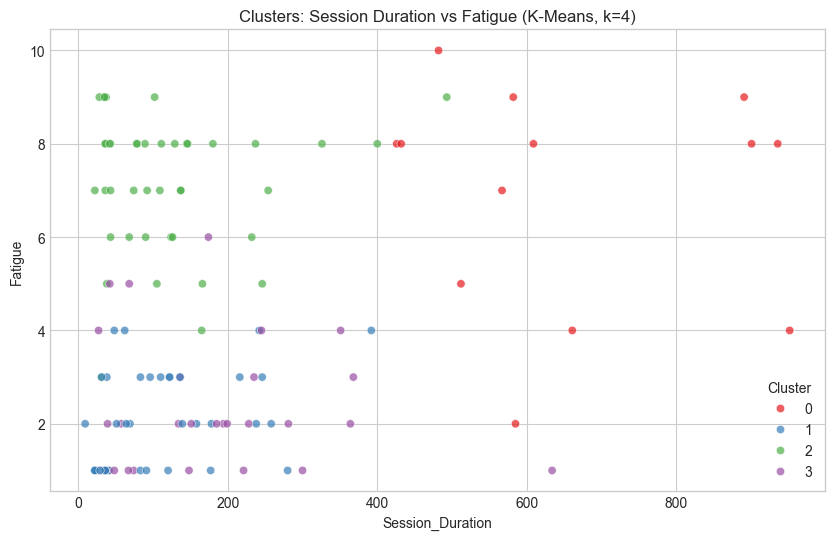

In [40]:
# Visualize clusters: Session Duration vs Fatigue, colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sessions, x='Session_Duration', y='Fatigue', hue='Cluster', palette='Set1', alpha=0.7)
plt.title('Clusters: Session Duration vs Fatigue (K-Means, k={})'.format(k_opt))
save_fig('26_clusters_scatter.png'); plt.show()

In [41]:
# ANOVA: Compare Fatigue and Cognitive Strain across clusters
cluster_groups = [df_sessions[df_sessions['Cluster']==i]['Fatigue'].values for i in range(k_opt)]
f_stat, p_anova = f_oneway(*cluster_groups)
print("ANOVA (Fatigue across clusters): F = {:.3f}, p = {:.4f}".format(f_stat, p_anova))
with open(os.path.join(RESULTS_DIR, '36_anova_clusters.txt'), 'w') as f:
    f.write('ANOVA Fatigue across clusters: F = {:.3f}, p = {:.4f}\n'.format(f_stat, p_anova))

ANOVA (Fatigue across clusters): F = 110.305, p = 0.0000


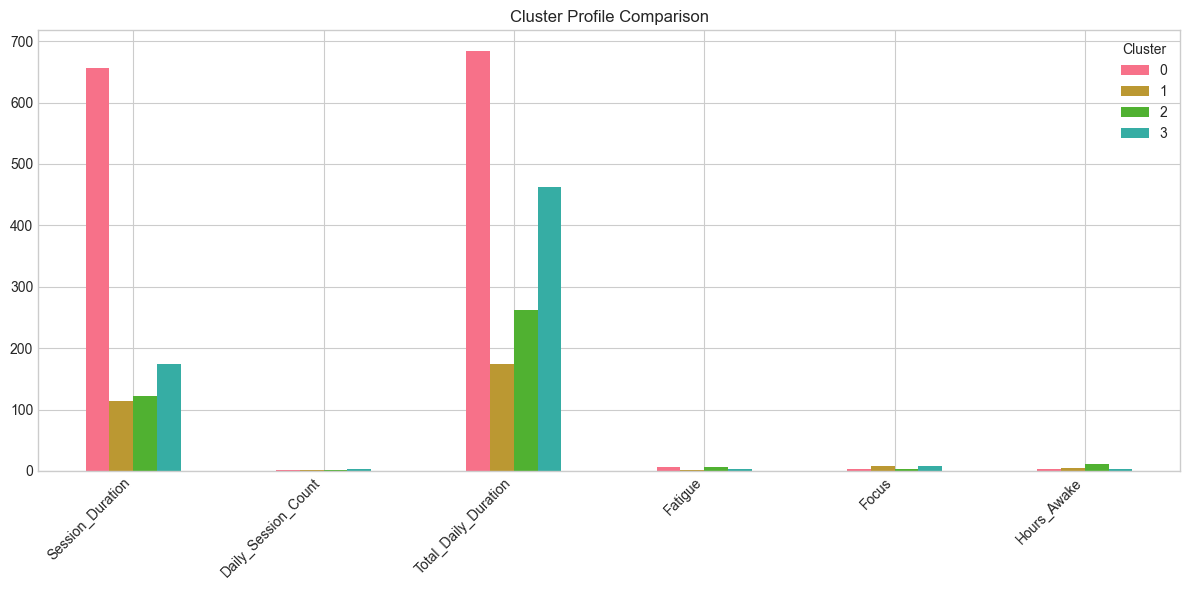

In [42]:
# Bar chart: Cluster characteristics comparison
cluster_profiles.T.plot(kind='bar', figsize=(12, 6))
plt.title('Cluster Profile Comparison')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster')
plt.tight_layout()
save_fig('27_cluster_profiles.png'); plt.show()

---
## 9. Time Series Analysis

Trends, moving averages, and temporal patterns.

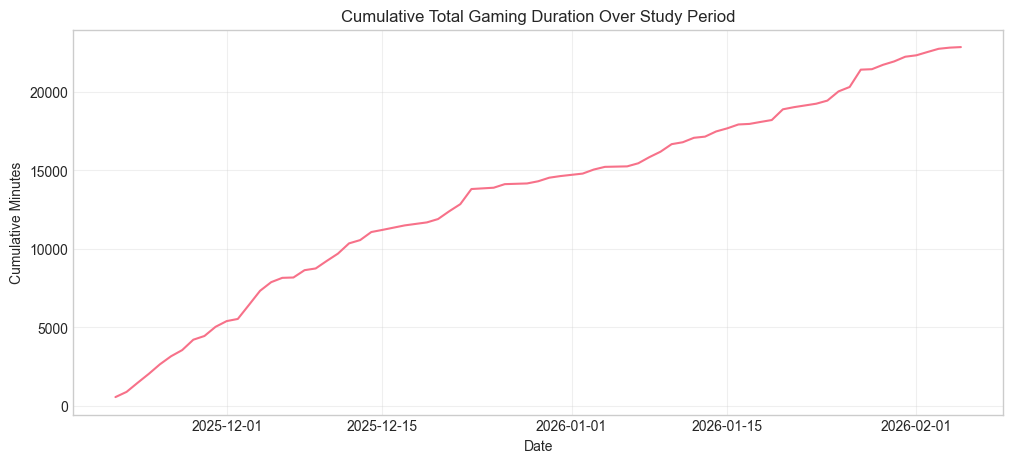

In [43]:
# Cumulative gaming time over study period
df_daily_sorted['Cumulative_Duration'] = df_daily_sorted['Total_Daily_Duration'].cumsum()
plt.figure(figsize=(12, 5))
plt.plot(df_daily_sorted['Date_dt'], df_daily_sorted['Cumulative_Duration'])
plt.title('Cumulative Total Gaming Duration Over Study Period')
plt.ylabel('Cumulative Minutes')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
save_fig('28_timeseries_cumulative.png'); plt.show()

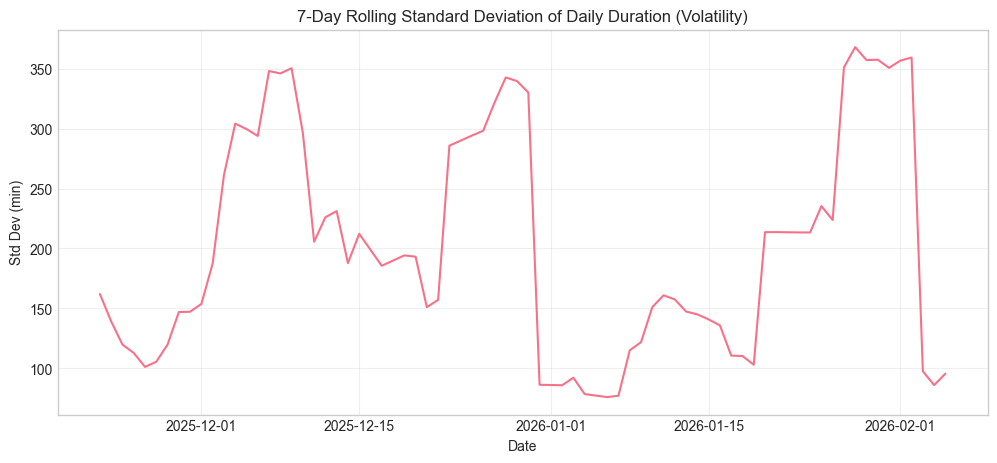

In [44]:
# Rolling statistics: 7-day rolling std (volatility)
df_daily_sorted['Duration_Rolling_Std'] = df_daily_sorted['Total_Daily_Duration'].rolling(7, min_periods=1).std()
plt.figure(figsize=(12, 5))
plt.plot(df_daily_sorted['Date_dt'], df_daily_sorted['Duration_Rolling_Std'])
plt.title('7-Day Rolling Standard Deviation of Daily Duration (Volatility)')
plt.ylabel('Std Dev (min)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
save_fig('29_timeseries_rolling_std.png'); plt.show()

---
## 10. Summary Statistics (Output Only)

In [45]:
# Quick summary statistics for report
print("=== KEY SUMMARY STATISTICS ===\n")
print("Total sessions analyzed:", len(df_sessions))
print("Study period:", df_sessions['Date Played'].min(), "to", df_sessions['Date Played'].max())
print("\nSession Duration: mean = {:.0f} min, median = {:.0f} min".format(
    df_sessions['Session_Duration'].mean(), df_sessions['Session_Duration'].median()))
print("Fatigue: mean = {:.2f}, Focus: mean = {:.2f}".format(
    df_sessions['Fatigue'].mean(), df_sessions['Focus'].mean()))
print("\nLate-night sessions: {} ({:.1f}%)".format(
    df_sessions['Late_Night'].sum(), 100*df_sessions['Late_Night'].mean()))
with open(os.path.join(RESULTS_DIR, '37_key_summary.txt'), 'w') as f:
    f.write(f'Total sessions: {len(df_sessions)}\nStudy period: {df_sessions["Date Played"].min()} to {df_sessions["Date Played"].max()}\n')
    f.write('Session Duration: mean = {:.0f} min, median = {:.0f} min\n'.format(df_sessions['Session_Duration'].mean(), df_sessions['Session_Duration'].median()))
    f.write('Fatigue mean = {:.2f}, Focus mean = {:.2f}\n'.format(df_sessions['Fatigue'].mean(), df_sessions['Focus'].mean()))
    f.write('Late-night sessions: {} ({:.1f}%)\n'.format(df_sessions['Late_Night'].sum(), 100*df_sessions['Late_Night'].mean()))

=== KEY SUMMARY STATISTICS ===

Total sessions analyzed: 120
Study period: 2025-11-21 00:00:00 to 2026-02-05 00:00:00

Session Duration: mean = 190 min, median = 123 min
Fatigue: mean = 4.45, Focus: mean = 5.67

Late-night sessions: 49 (40.8%)
